# **Bag-Of-Word Model**

In [1]:
import itertools
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import math

import nltk
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

ModuleNotFoundError: No module named 'keras'

In [ ]:
RANDOM_SEED = 123
DEVICE = "cuda"
path = 'ly_tag_4_19.csv'
ly = pd.read_csv(path, delimiter = ",", dtype = {'lyrics':str})


# take out lyrics
lyrics = ly['lyrics']

In [ ]:
ly.head(3)

ly['ctg_2'] = pd.Series(np.zeros_like(ly['category']))

tag_cat_dic = {'alternative': 0, 'dance': 1, 'indie': 2,
               'others': 3, 'pop': 4, 'rock': 5}

for i in range(0, len(ly['ctg_2'])):
  for j in set(ly['tags']):
    if ly.loc[i, 'tags'] == j:
      ly.loc[i, 'ctg_2'] = tag_cat_dic[j]

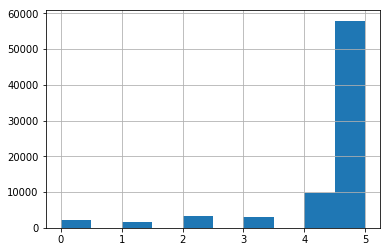

In [24]:
ly.ctg_2.hist()

In [ ]:
not_rock = ly.loc[:, 'ctg_2'] != 5
is_rock = ly.loc[:, 'ctg_2'] == 5

total_rock = sum(is_rock)
ratio_rock = 20_000/total_rock

np.random.seed(479)
rand_rock = np.random.uniform(size = ly.shape[0]) <= ratio_rock

slted = not_rock | (is_rock & rand_rock)

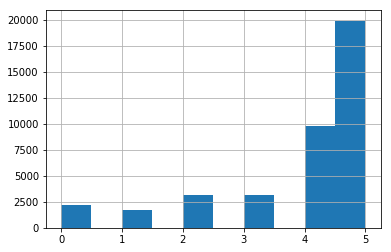

In [47]:
ly.loc[slted, 'ctg_2'].hist()

In [60]:
def calBaseAcu(label_series):
  'Use Beysian formula to calculate accuracy of random guess based on frequency of class labels'
  count = np.bincount(label_series)
  freq = count/sum(count)
  
  return(sum(freq**2))

print( calBaseAcu(ly.loc[:, 'ctg_2']) )
print( calBaseAcu(ly.loc[slted, 'ctg_2']) )

0.5736427105197036
0.3270865423676704


In [ ]:
import nltk
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;|\n]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
lyrics = lyrics.apply(clean_text)
ly["lyrics"]=lyrics


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#len(max(lyrics, key=len))

7201

In [ ]:
train_size = int(len(ly) * .7)
train_lyrics = ly['lyrics'][:train_size]
train_tags = ly['tags'][:train_size]

test_lyrics = ly['lyrics'][train_size:]
test_tags = ly['tags'][train_size:]

max_words = len(max(lyrics, key=len))
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_lyrics) # only fit on train

x_train = tokenize.texts_to_matrix(train_lyrics)
x_test = tokenize.texts_to_matrix(test_lyrics)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 2

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 49067 samples, validate on 5452 samples
Epoch 1/2
49067/49067 [==============================] - 100s 2ms/step - loss: 0.9402 - acc: 0.7409 - val_loss: 0.8844 - val_acc: 0.7493
Epoch 2/2
49067/49067 [==============================] - 98s 2ms/step - loss: 0.7969 - acc: 0.7471 - val_loss: 0.9145 - val_acc: 0.7476


In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

23366/23366 [==============================] - 7s 287us/step
Test accuracy: 0.7423606950218604
